# Analytical Marchenko-Pastur Simulation

In what follows, we look at the behaviour of the RG of the stochastic field theory of the **analytical** Marchenko–Pastur (MP) distribution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pde import CartesianGrid, MemoryStorage, ScalarField

plt.style.use('ggplot')

from ssd import SSD, MarchenkoPastur, TranslatedInverseMarchenkoPastur


## Functional Renormalization Group

We here simulate the behaviour of the functional RG.

In [3]:
# Parameters of the distribution
ratio = 0.8
mu = [0.0, 1.0, 0.0]
xinf = 0.0
xsup = 1.0
nval = 1000
nsteps = 500


We then visualize the corresponding Marchenko-Pastur distribution:

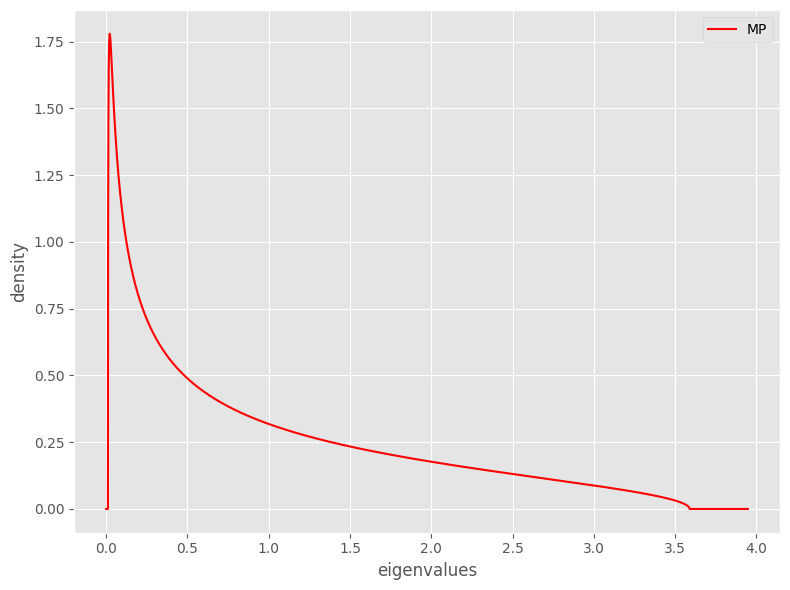

In [4]:
# Plot the Marchenko-Pastur distribution
mp = MarchenkoPastur(L=ratio)
x = np.linspace(0, mp.max * 1.1, num=10000)
y_0 = np.array([mp(xi) for xi in x])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y_0, 'r-', label='MP')
ax.set_xlabel('eigenvalues')
ax.set_ylabel('density')
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)


We then show the inverse distribution for reference:

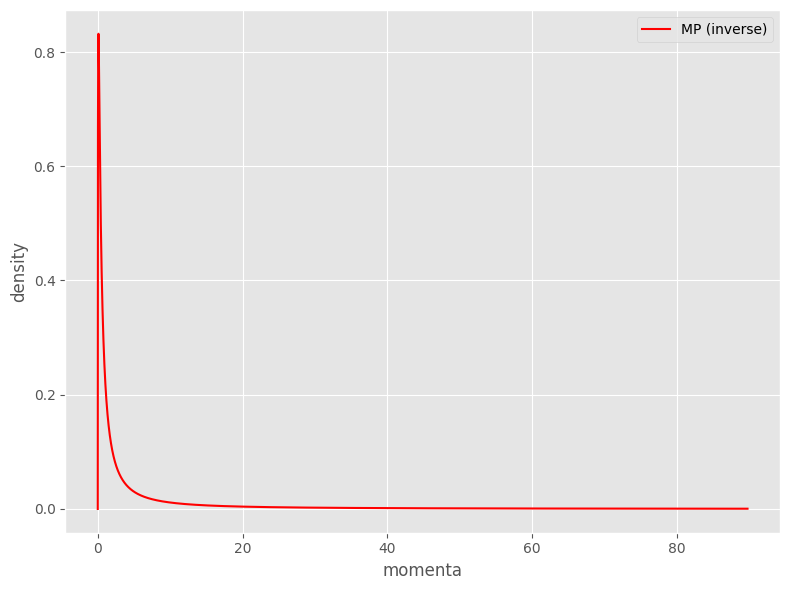

In [9]:
# Plot the inverse Marchenko-Pastur distribution
mp_inv = TranslatedInverseMarchenkoPastur(L=ratio)
x = np.linspace(0, 1 / mp.min, num=10000)
y_0 = np.array([mp_inv(xi) for xi in x])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y_0, 'r-', label='MP (inverse)')

ax.set_xlabel('momenta')
ax.set_ylabel('density')
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)


## Simulation

We can finally simulate the evolution of the FRG equation:

In [10]:
# Define the grid
grid = CartesianGrid(
    [[xinf, xsup]],  # range of x coordinates
    [nval],  # number of points in x direction
    periodic=False,  # periodicity in x direction
)
expression = f'{mu[0]} + {mu[1]} * x + {mu[2]} * x**2'
state = ScalarField.from_expression(grid, expression)  # initial state
bc = 'auto_periodic_neumann'

# Initialize a storage
t_range = [0.0, 0.1]
dt = (t_range[1] - t_range[0]) / nsteps
dt_viz = dt * nsteps / 5
storage = MemoryStorage()
storage_viz = MemoryStorage()
trackers = [
    'progress',
    'steady_state',
    storage.tracker(interval=dt),
    storage_viz.tracker(interval=dt_viz),
]

# Define the PDE and solve
eq = SSD(dist=mp_inv, noise=0.0, bc=bc)
_ = eq.solve(state, t_range=t_range, dt=dt, tracker=trackers)


  0%|          | 0.0/0.1 [00:00<?, ?it/s]              /home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:511: RuntimeWarning: overflow encountered in power
  op(self.data, other, out=result.data)
/home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:511: RuntimeWarning: overflow encountered in multiply
  op(self.data, other, out=result.data)
/home/rf265700/Code/stochastic-signal-detection/venv/lib/python3.10/site-packages/pde/fields/base.py:505: RuntimeWarning: invalid value encountered in divide
  op(self.data, other.data, out=result.data)
100%|██████████| 0.1/0.1 [00:00<00:00,  4.70s/it]


## Visualisation

We finally visualise the results, as functions of the stochastic time.

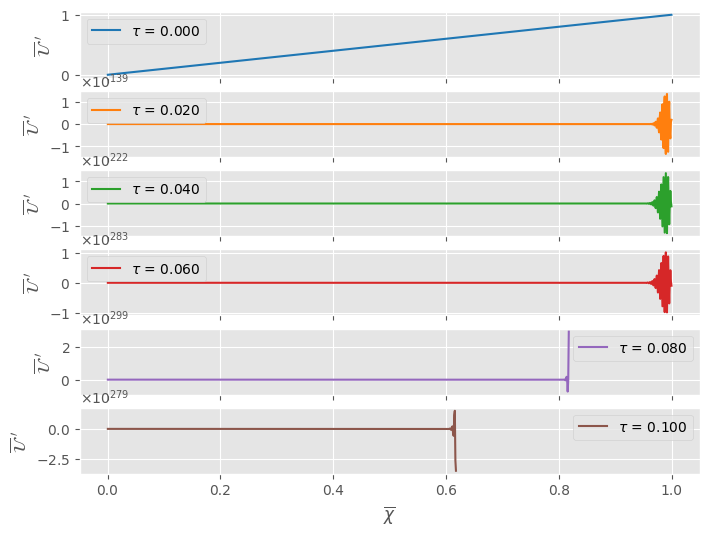

In [11]:
# Visualize the simulation at fixed time steps
fig, ax = plt.subplots(nrows=len(storage_viz), figsize=(8, 6), sharex=True)
cmap = plt.get_cmap('tab10')
for n, (time, field) in enumerate(storage_viz.items()):

    # Collect data
    x = field.grid.axes_coords[0]
    y_0 = field.data

    # Plot the field
    ax[n].plot(x, y_0, color=cmap(n), label=rf'$\tau$ = {time:.3f}')
    ax[n].set_xlabel(r'$\overline{\chi}$')
    ax[n].set_ylabel(r'$\overline{\mathcal{U}}^{~\prime}$')
    ax[n].legend(loc='best')
    ax[n].ticklabel_format(axis='y',
                           style='sci',
                           scilimits=(0, 0),
                           useMathText=True)
plt.show()
plt.close(fig)


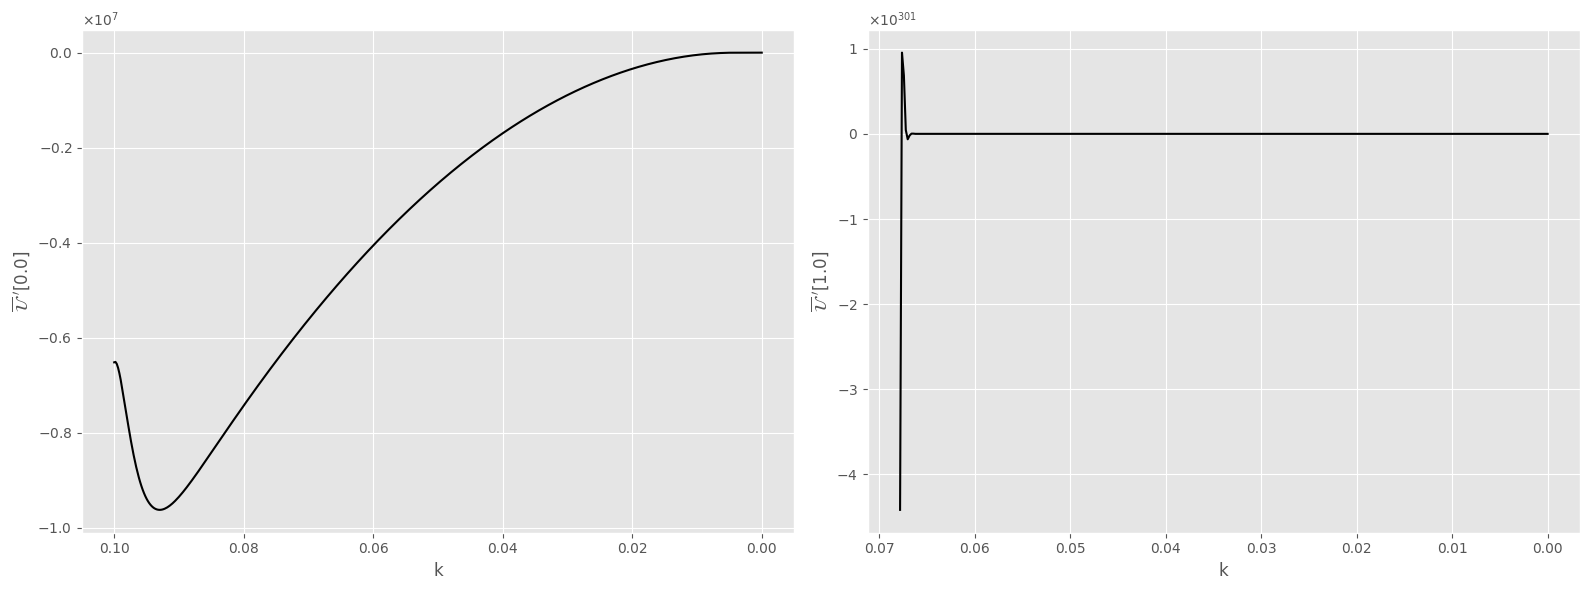

In [12]:
# Visualize the evolution of the field in a given position
t = []
y_0 = []
y_1 = []
for time, field in storage.items():

    # Collect data
    t.append(time)
    y_0.append(field.data[0])
    y_1.append(field.data[-1])
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].plot(t, y_0, 'k-')
ax[0].set_xlabel('k')
ax[0].invert_xaxis()
ax[0].set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{xinf}]$')
ax[0].ticklabel_format(axis='y',
                       style='sci',
                       scilimits=(0, 0),
                       useMathText=True)
ax[1].plot(t, y_1, 'k-')
ax[1].set_xlabel('k')
ax[1].invert_xaxis()
ax[1].set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{xsup}]$')
ax[1].ticklabel_format(axis='y',
                       style='sci',
                       scilimits=(0, 0),
                       useMathText=True)
plt.tight_layout()
plt.show()
plt.close(fig)
